#Diabetic Retinopathy with EfiicientNet
##Classes:
1. Mild
2. Moderate
3. No_DR
4. Proliferate_DR
5. Severe

Links to datasets & research papers:
- Dataset: https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-224x224-2019-data(DO NOT FORGET TO CITE IN REPORT)
- Notebook: https://www.kaggle.com/code/pkdarabi/diagnosis-of-diabetic-retinopathy-by-cnn-pytorch/notebook
- Referenec: https://www.sciencedirect.com/science/article/pii/S2352914820302069
- Reference: https://www.nature.com/articles/s41598-025-85752-2

- Diabetic foot ulcer detection using deep learning approaches: https://www.sciencedirect.com/science/article/pii/S2666351122000559



In [ ]:
!pip -q install timm==1.0.9 tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 44.7 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow matplotlib scikit-learn numpy pandas pillow

In [ ]:
import zipfile
import os
import re
from pathlib import Path

zip_path = '/content/DIABETIC_RETINA.zip'

extract_dir = '/content/DR_Data'
os.makedirs(extract_dir, exist_ok=True)

print("Extracting ZIP file...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Extracted to: {extract_dir}")

Extracting ZIP file...
Extracted to: /content/DR_Data


In [ ]:
extract_dir = '/content/DR_Data/DIABETIC_RETINA/colored_images'

def explore_directory_structure(start_path):
    print("Directory Structure:")
    for root, dirs, files in os.walk(start_path):
        level = root.replace(start_path, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 2 * (level + 1)
        for file in files[:5]:  # Show first 5 files
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                print(f'{subindent}{file}')
        if len(files) > 5:
            print(f'{subindent}... and {len(files) - 5} more files')

explore_directory_structure(extract_dir)

# count image files
def count_images(directory):
    image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')
    image_count = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(image_extensions):
                image_count += 1
    return image_count

total_images = count_images(extract_dir)
print(f"\nTotal image files found: {total_images}")

Directory Structure:

Total image files found: 0


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
from sklearn.utils.class_weight import compute_class_weight
import shutil
from sklearn.model_selection import train_test_split

In [ ]:
def organize_dataset_complete(source_base_dir, target_base_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Automatically organizes images into train/valid/test folders
    """
    # create target directory structure
    splits = ['train', 'valid', 'test']
    classes = ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

    for split in splits:
        for class_name in classes:
            os.makedirs(os.path.join(target_base_dir, split, class_name), exist_ok=True)

    # process each class
    for class_name in classes:
        source_class_dir = os.path.join(source_base_dir, class_name)

        if not os.path.exists(source_class_dir):
            print(f"Warning: {source_class_dir} not found. Skipping...")
            continue

        # get all images
        images = []
        for ext in ['.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG']:
            images.extend([f for f in os.listdir(source_class_dir) if f.lower().endswith(ext.lower())])

        if not images:
            print(f"No images found in {source_class_dir}")
            continue

        print(f"Processing {class_name}: {len(images)} images")

        # split the data
        train_files, temp_files = train_test_split(images, train_size=train_ratio, random_state=42)
        val_files, test_files = train_test_split(temp_files, test_size=test_ratio/(val_ratio+test_ratio), random_state=42)

        # copy files to destination directories
        def copy_to_destination(files, split_name):
            for file in files:
                src = os.path.join(source_class_dir, file)
                dst = os.path.join(target_base_dir, split_name, class_name, file)
                shutil.copy2(src, dst)

        copy_to_destination(train_files, 'train')
        copy_to_destination(val_files, 'valid')
        copy_to_destination(test_files, 'test')

        print(f"   Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test_files)}")

source_dir = '/content/DR_Data/colored_images'
target_dir = '/content/DR_org'

organize_dataset_complete(source_dir, target_dir)

Processing Mild: 740 images
   Train: 518, Val: 111, Test: 111
Processing Moderate: 1998 images
   Train: 1398, Val: 300, Test: 300
Processing No_DR: 3610 images
   Train: 2527, Val: 541, Test: 542
Processing Proliferate_DR: 590 images
   Train: 413, Val: 88, Test: 89
Processing Severe: 386 images
   Train: 270, Val: 58, Test: 58


In [ ]:
import os, math, time, copy, random
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
import timm
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
# Repro
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

In [ ]:
# Path
ROOT = Path("/content/DR_org")
TRAIN_DIR = ROOT / "train"
VAL_DIR   = ROOT / "valid"
TEST_DIR  = ROOT / "test"

assert TRAIN_DIR.exists() and VAL_DIR.exists() and TEST_DIR.exists(), "Check DR_org/train|valid|test paths"

In [ ]:
# Configuration
CFG = {
    "img_size": 384,
    "batch_size": 16,
    "epochs": 30,
    "model_name": "tf_efficientnet_b3_ns",
    "lr": 3e-4,
    "weight_decay": 1e-5,
    "patience": 5,              # early stopping
    "num_workers": 2,
    "label_smoothing": 0.05,
    "use_amp": True,
    "freeze_backbone_epochs": 1
}

In [ ]:
# Device confirmation
def pick_device():
    if torch.cuda.is_available(): return "cuda"
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available(): return "mps"
    return "cpu"
device = torch.device(pick_device())
print("Device:", device)


Device: cuda


In [ ]:
# Tranforms
IMNET_MEAN = (0.485, 0.456, 0.406)
IMNET_STD  = (0.229, 0.224, 0.225)

train_tfms = transforms.Compose([
    transforms.Resize(int(CFG["img_size"]*1.1)),
    transforms.RandomResizedCrop(CFG["img_size"], scale=(0.8, 1.0), ratio=(0.8, 1.2)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.1),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.15, 0.15, 0.10, 0.05),
    transforms.ToTensor(),
    transforms.Normalize(IMNET_MEAN, IMNET_STD),
])

val_tfms = transforms.Compose([
    transforms.Resize(int(CFG["img_size"]*1.1)),
    transforms.CenterCrop(CFG["img_size"]),
    transforms.ToTensor(),
    transforms.Normalize(IMNET_MEAN, IMNET_STD),
])

In [ ]:
# Datasets / Classes num confirmation
train_ds = datasets.ImageFolder(str(TRAIN_DIR), transform=train_tfms)
val_ds   = datasets.ImageFolder(str(VAL_DIR),   transform=val_tfms)
test_ds  = datasets.ImageFolder(str(TEST_DIR),  transform=val_tfms)

idx_to_class = {v:k for k,v in train_ds.class_to_idx.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]
num_classes = len(class_names)
print("Classes:", class_names)

Classes: ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']


In [ ]:
# Compute class weights (for imbalance)
counts = np.zeros(num_classes, dtype=int)
for _, label in train_ds.samples:
    counts[label] += 1
print("Train counts per class:", {class_names[i]: int(counts[i]) for i in range(num_classes)})

# Inverse frequency weights for CrossEntropy
class_weights = 1.0 / np.clip(counts, 1, None)
class_weights = class_weights / class_weights.sum() * num_classes
class_weights_t = torch.tensor(class_weights, dtype=torch.float32, device=device)
print("Class weights:", {class_names[i]: float(class_weights[i]) for i in range(num_classes)})

# Weighted sampler (for heavy imbalance)
sample_weights = [class_weights[s[1]] for s in train_ds.samples]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

Train counts per class: {'Mild': 335, 'Moderate': 896, 'No_DR': 1647, 'Proliferate_DR': 270, 'Severe': 176}
Class weights: {'Mild': 1.0590003217938182, 'Moderate': 0.39594320067067973, 'No_DR': 0.21540079405035162, 'Proliferate_DR': 1.3139448437071446, 'Severe': 2.015710839778006}


In [ ]:
# Loaders
train_dl = DataLoader(train_ds, batch_size=CFG["batch_size"], sampler=sampler,
                      num_workers=CFG["num_workers"], pin_memory=True)
val_dl   = DataLoader(val_ds, batch_size=CFG["batch_size"], shuffle=False,
                      num_workers=CFG["num_workers"], pin_memory=True)
test_dl  = DataLoader(test_ds, batch_size=CFG["batch_size"], shuffle=False,
                      num_workers=CFG["num_workers"], pin_memory=True)


In [ ]:
# Model
model = timm.create_model(CFG["model_name"], pretrained=True, num_classes=num_classes)
model.to(device)

def set_backbone_trainable(is_trainable: bool):
    for name, p in model.named_parameters():
        if "classifier" in name or "fc" in name or "head" in name:
            p.requires_grad = True
        else:
            p.requires_grad = is_trainable

set_backbone_trainable(False)


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b3_ns to current tf_efficientnet_b3.ns_jft_in1k.
  model = create_fn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

In [ ]:
# Loss, Optim, Sched
criterion = nn.CrossEntropyLoss(weight=class_weights_t, label_smoothing=CFG["label_smoothing"])
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                              lr=CFG["lr"], weight_decay=CFG["weight_decay"])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CFG["epochs"])

scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda" and CFG["use_amp"]))

/tmp/ipython-input-1270165410.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda" and CFG["use_amp"]))


In [ ]:
# Train/Eval helpers
def run_one_epoch(dl, model, optimizer=None, scaler=None):
    is_train = optimizer is not None
    model.train(is_train)
    total, correct, running_loss = 0, 0, 0.0

    for imgs, labels in tqdm(dl, disable=False):
        imgs, labels = imgs.to(device), labels.to(device)

        if is_train:
            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=(device.type == "cuda" and CFG["use_amp"])):
                logits = model(imgs)
                loss = criterion(logits, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            with torch.no_grad():
                logits = model(imgs)
                loss = criterion(logits, labels)

        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)

    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc

def evaluate(dl, model):
    model.eval()
    total, correct, running_loss = 0, 0, 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in dl:
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs)
            loss = criterion(logits, labels)
            running_loss += loss.item() * imgs.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += imgs.size(0)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    avg_loss = running_loss / total
    acc = correct / total
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return avg_loss, acc, all_preds, all_labels


In [ ]:
# Training loop (with early stopping, checkpoints)
best_val_acc = 0.0
best_state = None
epochs_no_improve = 0

for epoch in range(1, CFG["epochs"]+1):
    print(f"\nEpoch {epoch}/{CFG['epochs']}  (lr={scheduler.get_last_lr()[0]:.2e})")

    if epoch == CFG["freeze_backbone_epochs"] + 1:
        set_backbone_trainable(True)
        # reinit optimizer to include backbone params
        optimizer = torch.optim.AdamW(model.parameters(), lr=CFG["lr"], weight_decay=CFG["weight_decay"])

    train_loss, train_acc = run_one_epoch(train_dl, model, optimizer, scaler)
    val_loss, val_acc, _, _ = evaluate(val_dl, model)
    scheduler.step()

    print(f"  Train: loss={train_loss:.4f}, acc={train_acc*100:.2f}%")
    print(f"  Valid: loss={val_loss:.4f}, acc={val_acc*100:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
        torch.save(best_state, "/content/best_efficientnet_dr.pth")
        print("  Saved new best model")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= CFG["patience"]:
            print("  Early stopping triggered")
            break


Epoch 1/30  (lr=3.00e-04)


  0%|          | 0/208 [00:00<?, ?it/s]/tmp/ipython-input-2911779617.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda" and CFG["use_amp"])):
100%|██████████| 208/208 [01:28<00:00,  2.34it/s]


  Train: loss=1.3930, acc=42.69%
  Valid: loss=4.0769, acc=16.65%
  Saved new best model

Epoch 2/30  (lr=2.99e-04)


100%|██████████| 208/208 [01:39<00:00,  2.09it/s]


  Train: loss=1.1016, acc=56.11%
  Valid: loss=1.4187, acc=69.83%
  Saved new best model

Epoch 3/30  (lr=2.97e-04)


100%|██████████| 208/208 [01:23<00:00,  2.51it/s]


  Train: loss=0.7279, acc=69.10%
  Valid: loss=1.4659, acc=62.59%

Epoch 4/30  (lr=2.93e-04)


100%|██████████| 208/208 [01:22<00:00,  2.53it/s]


  Train: loss=0.5978, acc=75.54%
  Valid: loss=1.3493, acc=69.74%

Epoch 5/30  (lr=2.87e-04)


100%|██████████| 208/208 [01:22<00:00,  2.52it/s]


  Train: loss=0.5038, acc=82.43%
  Valid: loss=1.1665, acc=77.86%
  Saved new best model

Epoch 6/30  (lr=2.80e-04)


100%|██████████| 208/208 [01:24<00:00,  2.46it/s]


  Train: loss=0.4785, acc=84.12%
  Valid: loss=1.1182, acc=78.55%
  Saved new best model

Epoch 7/30  (lr=2.71e-04)


100%|██████████| 208/208 [01:23<00:00,  2.48it/s]


  Train: loss=0.4165, acc=86.88%
  Valid: loss=0.9760, acc=85.01%
  Saved new best model

Epoch 8/30  (lr=2.61e-04)


100%|██████████| 208/208 [01:22<00:00,  2.52it/s]


  Train: loss=0.3994, acc=89.65%
  Valid: loss=1.0273, acc=82.08%

Epoch 9/30  (lr=2.50e-04)


100%|██████████| 208/208 [01:25<00:00,  2.42it/s]


  Train: loss=0.3774, acc=90.25%
  Valid: loss=0.9766, acc=87.66%
  Saved new best model

Epoch 10/30  (lr=2.38e-04)


100%|██████████| 208/208 [01:22<00:00,  2.52it/s]


  Train: loss=0.3626, acc=92.00%
  Valid: loss=0.9352, acc=88.05%
  Saved new best model

Epoch 11/30  (lr=2.25e-04)


100%|██████████| 208/208 [01:21<00:00,  2.54it/s]


  Train: loss=0.3392, acc=93.68%
  Valid: loss=0.9465, acc=87.37%

Epoch 12/30  (lr=2.11e-04)


100%|██████████| 208/208 [01:24<00:00,  2.47it/s]


  Train: loss=0.3312, acc=93.35%
  Valid: loss=0.9200, acc=87.07%

Epoch 13/30  (lr=1.96e-04)


100%|██████████| 208/208 [01:22<00:00,  2.51it/s]


  Train: loss=0.3307, acc=93.65%
  Valid: loss=0.8731, acc=90.11%
  Saved new best model

Epoch 14/30  (lr=1.81e-04)


100%|██████████| 208/208 [01:24<00:00,  2.45it/s]


  Train: loss=0.2996, acc=95.55%
  Valid: loss=0.8514, acc=91.38%
  Saved new best model

Epoch 15/30  (lr=1.66e-04)


100%|██████████| 208/208 [01:22<00:00,  2.53it/s]


  Train: loss=0.3236, acc=94.01%
  Valid: loss=0.8454, acc=90.70%

Epoch 16/30  (lr=1.50e-04)


100%|██████████| 208/208 [01:22<00:00,  2.53it/s]


  Train: loss=0.3300, acc=94.86%
  Valid: loss=0.8143, acc=93.44%
  Saved new best model

Epoch 17/30  (lr=1.34e-04)


100%|██████████| 208/208 [01:21<00:00,  2.56it/s]


  Train: loss=0.3052, acc=95.49%
  Valid: loss=0.8404, acc=93.54%
  Saved new best model

Epoch 18/30  (lr=1.19e-04)


100%|██████████| 208/208 [01:24<00:00,  2.46it/s]


  Train: loss=0.2845, acc=96.48%
  Valid: loss=0.8188, acc=93.05%

Epoch 19/30  (lr=1.04e-04)


100%|██████████| 208/208 [01:23<00:00,  2.49it/s]


  Train: loss=0.2909, acc=96.12%
  Valid: loss=0.7936, acc=94.22%
  Saved new best model

Epoch 20/30  (lr=8.90e-05)


100%|██████████| 208/208 [01:25<00:00,  2.43it/s]


  Train: loss=0.2958, acc=95.28%
  Valid: loss=0.8145, acc=94.03%

Epoch 21/30  (lr=7.50e-05)


100%|██████████| 208/208 [01:24<00:00,  2.46it/s]


  Train: loss=0.2940, acc=96.81%
  Valid: loss=0.8205, acc=92.07%

Epoch 22/30  (lr=6.18e-05)


100%|██████████| 208/208 [01:22<00:00,  2.51it/s]


  Train: loss=0.2906, acc=96.36%
  Valid: loss=0.8037, acc=93.63%

Epoch 23/30  (lr=4.96e-05)


100%|██████████| 208/208 [01:24<00:00,  2.47it/s]


  Train: loss=0.2769, acc=96.75%
  Valid: loss=0.8103, acc=93.93%

Epoch 24/30  (lr=3.85e-05)


100%|██████████| 208/208 [01:23<00:00,  2.50it/s]


  Train: loss=0.3066, acc=96.12%
  Valid: loss=0.8034, acc=93.24%
  Early stopping triggered


In [ ]:
# Load best and evaluate on test
if best_state is not None:
    model.load_state_dict(best_state)
else:
    print("Warning: No best state saved; using last epoch weights.")

test_loss, test_acc, test_preds, test_labels = evaluate(test_dl, model)
print(f"\nTEST: loss={test_loss:.4f}, acc={test_acc*100:.2f}%")

print("\nClassification Report (Test):")
print(classification_report(test_labels, test_preds, target_names=class_names, digits=4))



TEST: loss=0.7930, acc=94.57%

Classification Report (Test):
                precision    recall  f1-score   support

          Mild     0.8824    0.8911    0.8867       101
      Moderate     0.9331    0.9228    0.9279       272
         No_DR     1.0000    0.9842    0.9920       506
Proliferate_DR     0.8795    0.9012    0.8902        81
        Severe     0.7541    0.8679    0.8070        53

      accuracy                         0.9457      1013
     macro avg     0.8898    0.9134    0.9008      1013
  weighted avg     0.9478    0.9457    0.9465      1013



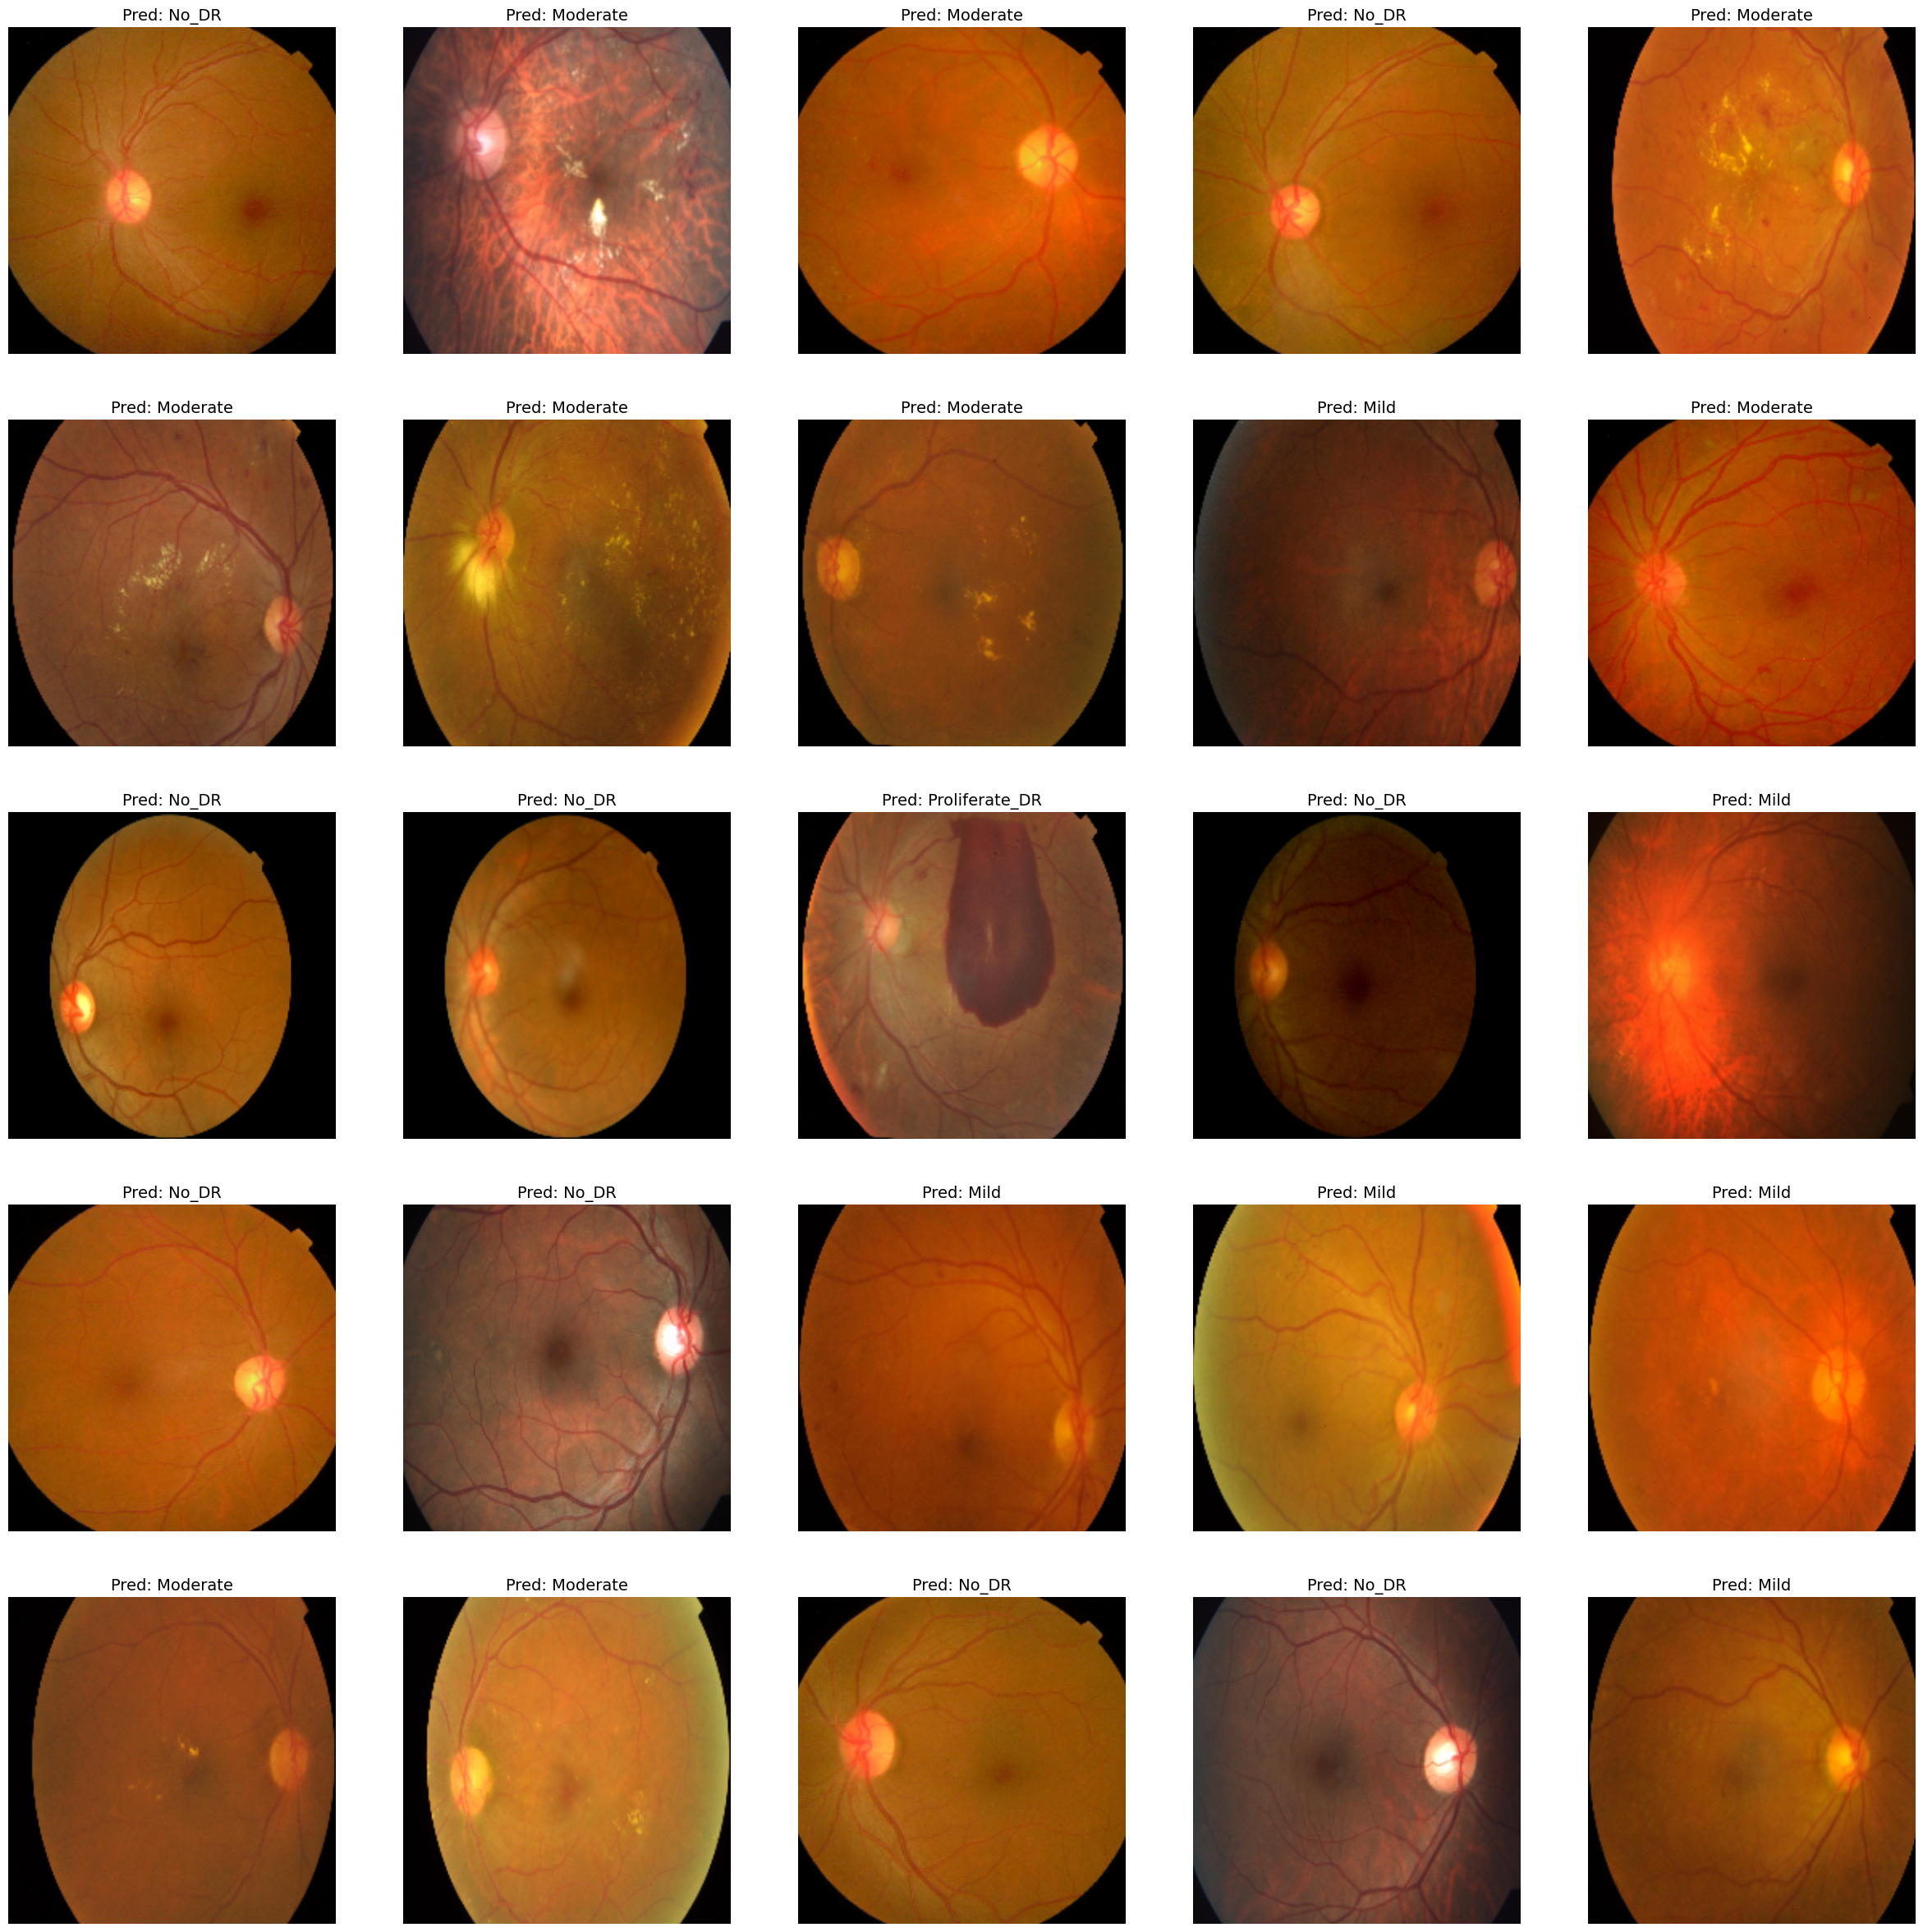

In [ ]:
def unnormalize(img_tensor, mean=IMNET_MEAN, std=IMNET_STD):
    # img_tensor: C x H x W
    img = img_tensor.clone()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return img

# visualization
model.eval()
indices = random.sample(range(len(test_ds)), 25)

plt.figure(figsize=(30, 30))
plt.tight_layout()

for i, idx in enumerate(indices):
    img, true_label = test_ds[idx]
    img_disp = unnormalize(img).clamp(0, 1)

    with torch.no_grad():
        logits = model(img.unsqueeze(0).to(device))
        pred = torch.argmax(logits, dim=1).item()

    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(np.transpose(img_disp.numpy(), (1, 2, 0)))  # back to HWC
    plt.title(f"Pred: {class_names[pred]}", fontsize=14)
    plt.axis("off")

plt.show()


In [ ]:
from PIL import Image
import numpy as np
import torch.nn.functional as F
from torchvision import transforms as T

CLASS_NAMES = ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']
IMG_SIZE = 384
IMNET_MEAN = (0.485, 0.456, 0.406)
IMNET_STD  = (0.229, 0.224, 0.225)

val_tfms = T.Compose([
    T.Resize(int(IMG_SIZE*1.1)),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(IMNET_MEAN, IMNET_STD),
])

def predict_path(path):
    img = Image.open(path).convert("RGB")
    x = val_tfms(img).unsqueeze(0).to(next(model.parameters()).device)
    with torch.no_grad():
        probs = F.softmax(model(x), dim=1).cpu().numpy()[0]
    i = int(np.argmax(probs))
    print("Top:", CLASS_NAMES[i], f"({probs[i]*100:.2f}%)")
    print({CLASS_NAMES[j]: float(p) for j, p in enumerate(probs)})


predict_path("/content/DR_org/test/Severe/070f67572d03.png")


Top: Severe (99.27%)
{'Mild': 0.003793081035837531, 'Moderate': 0.0005691067781299353, 'No_DR': 0.0002539180568419397, 'Proliferate_DR': 0.0026483898982405663, 'Severe': 0.9927353858947754}


In [ ]:
# RETINA — visualizations
import numpy as np, matplotlib.pyplot as plt, torch, torch.nn.functional as F, itertools, random
from torchvision import datasets
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from PIL import Image

RET_TRAIN, RET_VAL, RET_TEST = "/content/DR_org/train", "/content/DR_org/valid", "/content/DR_org/test"
ret_test_ds = datasets.ImageFolder(str(RET_TEST), transform=val_tfms)
ret_class_names = CLASS_NAMES  # from json earlier

def retina_predict_batch(xb):
    with torch.no_grad():
        logits = m(xb.to(device))
        probs = F.softmax(logits, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)
    return preds, probs


/tmp/ipython-input-1335249297.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ret_class_names, rotation=20, ha="right")
/tmp/ipython-input-1335249297.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ret_class_names, rotation=20, ha="right")
/tmp/ipython-input-1335249297.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ret_class_names, rotation=20, ha="right")


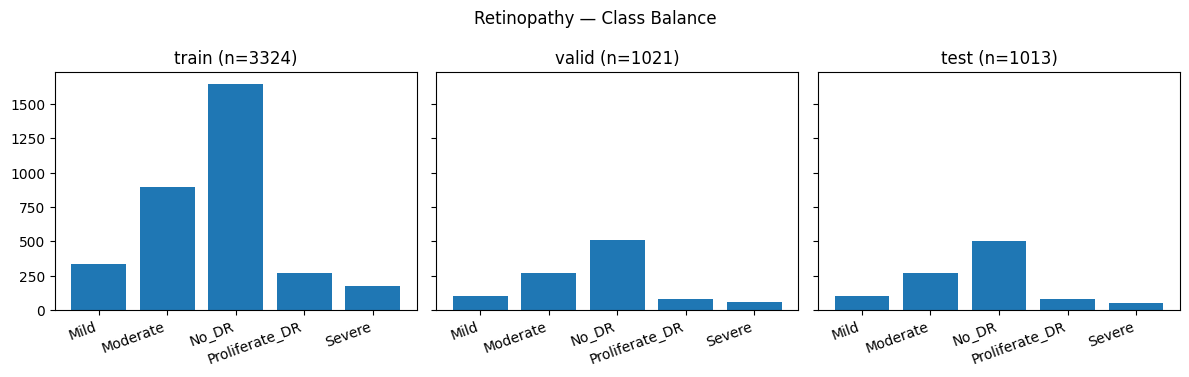

In [ ]:
# Balance
def plot_class_balance_ret():
    splits = {"train": RET_TRAIN, "valid": RET_VAL, "test": RET_TEST}
    fig, axes = plt.subplots(1,3, figsize=(12,3.8), sharey=True)
    for ax, (name, d) in zip(axes, splits.items()):
        ds = datasets.ImageFolder(str(d))
        counts = [0]*len(ret_class_names)
        for _, y in ds.samples: counts[y]+=1
        ax.bar(ret_class_names, counts)
        ax.set_title(f"{name} (n={sum(counts)})")
        ax.set_xticklabels(ret_class_names, rotation=20, ha="right")
    fig.suptitle("Retinopathy — Class Balance"); plt.tight_layout(); plt.show()

plot_class_balance_ret()

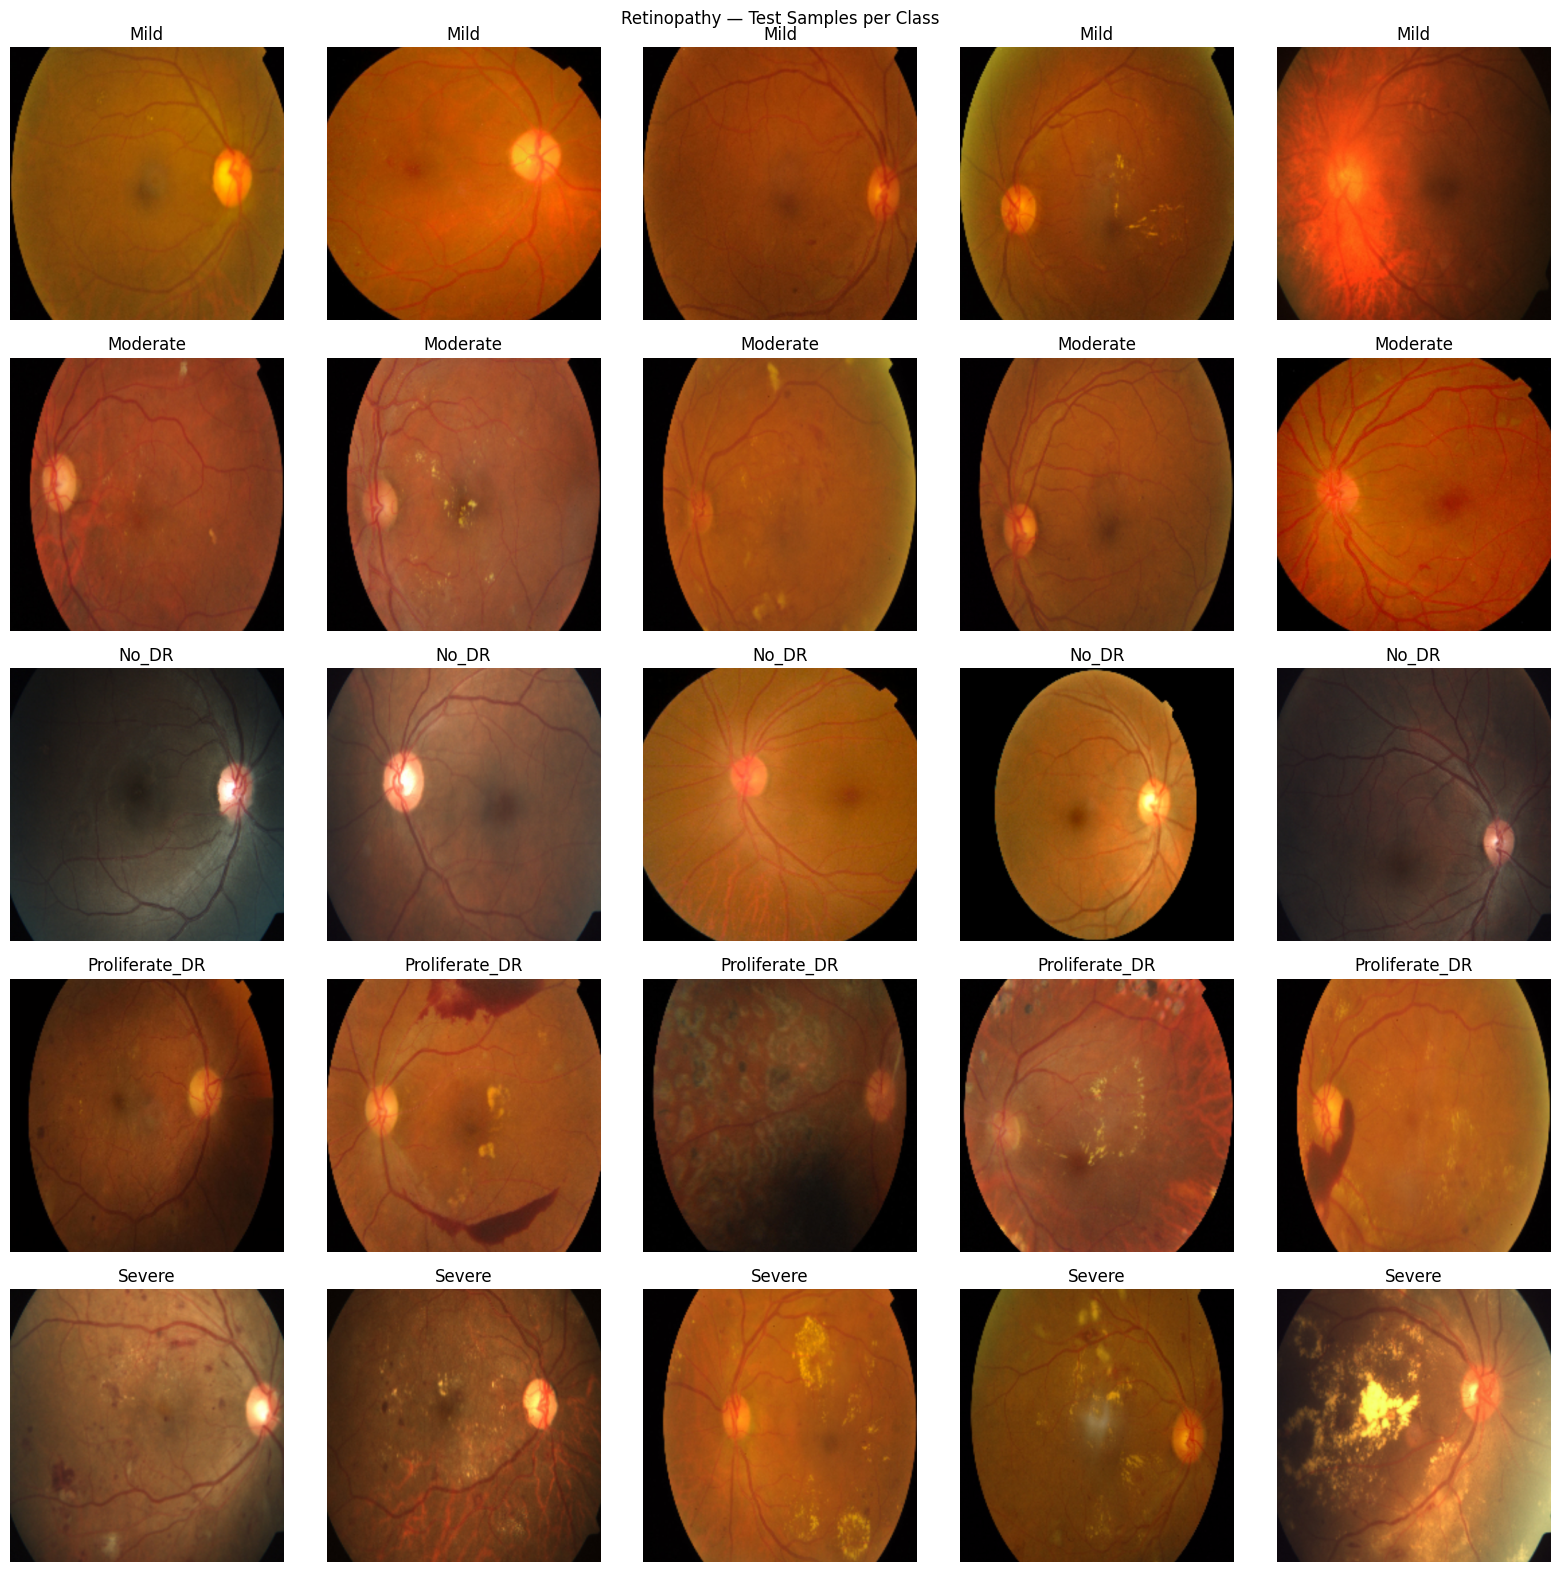

In [ ]:
# sample grid
def show_samples_per_class_ret(k=5):
    raw = datasets.ImageFolder(str(RET_TEST), transform=val_tfms)
    idxs_by_class = {i: [] for i in range(len(ret_class_names))}
    for i, (_, y) in enumerate(raw.samples): idxs_by_class[y].append(i)
    rows, cols = len(ret_class_names), k
    plt.figure(figsize=(3.2*cols, 3.2*rows))
    for r, cidx in enumerate(range(len(ret_class_names))):
        picks = random.sample(idxs_by_class[cidx], min(k, len(idxs_by_class[cidx])))
        for c, idx in enumerate(picks):
            img, _ = raw[idx]
            img_disp = img.clone()
            for t, m, s in zip(img_disp, (0.485,0.456,0.406), (0.229,0.224,0.225)):
                t.mul_(s).add_(m)
            ax = plt.subplot(rows, cols, r*cols+c+1)
            ax.imshow(np.clip(img_disp.permute(1,2,0).numpy(), 0, 1)); ax.axis("off")
            ax.set_title(ret_class_names[cidx])
    plt.suptitle("Retinopathy — Test Samples per Class"); plt.tight_layout(); plt.show()

show_samples_per_class_ret(k=5)

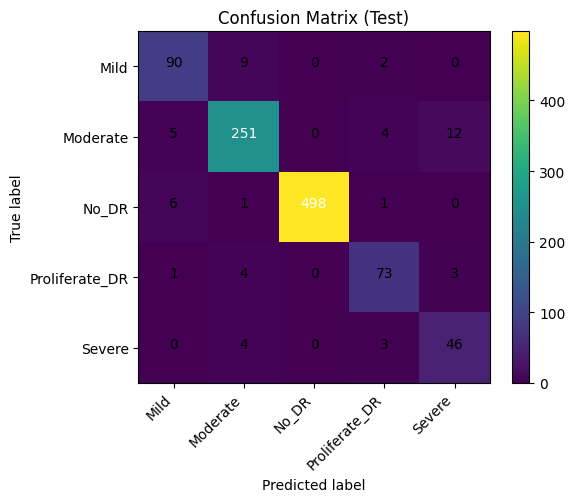


Saved best weights to /content/best_efficientnet_dr.pth


In [ ]:
# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds, labels=list(range(num_classes)))
fig = plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Test)")
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)
th = cm.max() / 2
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(cm[i, j], "d"),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > th else "black")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

print("\nSaved best weights to /content/best_efficientnet_dr.pth")

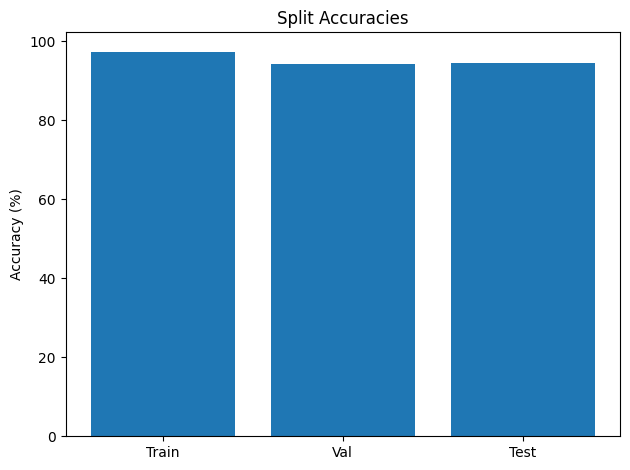

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Accuracy bar chart for Train / Val / Test
split_names, split_accs = [], []

# Train
try:
    train_loss, train_acc, _, _ = evaluate(train_dl, model)
    split_names.append("Train"); split_accs.append(train_acc * 100)
except Exception as e:
    print("Train eval skipped:", e)

# Val
try:
    val_loss, val_acc, _, _ = evaluate(val_dl, model)
    split_names.append("Val"); split_accs.append(val_acc * 100)
except Exception as e:
    print("Val eval skipped:", e)

# Test (optional)
try:
    test_loss, test_acc, _, _ = evaluate(test_dl, model)
    split_names.append("Test"); split_accs.append(test_acc * 100)
except Exception as e:
    print("Test eval skipped:", e)

if split_names:
    x = np.arange(len(split_names))
    plt.figure()
    plt.bar(x, split_accs)
    plt.xticks(x, split_names)
    plt.ylabel("Accuracy (%)")
    plt.title("Split Accuracies")
    plt.tight_layout()
    plt.show()
else:
    print("No splits evaluated. Make sure train_dl/val_dl/test_dl and model are defined.")

In [ ]:
# 2) Class distributions (TRUE labels only) for each split
def _labels_from_dataloader(dl):
    if dl is None or not hasattr(dl, "dataset"):
        return None
    ds = dl.dataset
    # common attributes
    for attr in ["targets", "labels", "y", "ys"]:
        if hasattr(ds, attr):
            y = getattr(ds, attr)
            if torch.is_tensor(y):
                y = y.cpu().numpy()
            return np.array(y)
    # fallback: iterate the dataset
    ys = []
    try:
        for i in range(len(ds)):
            item = ds[i]
            if isinstance(item, dict):
                lab = item.get("label", item.get("y", None))
            elif isinstance(item, (list, tuple)) and len(item) >= 2:
                lab = item[1]
            else:
                lab = None
            if lab is None:
                break
            if torch.is_tensor(lab):
                lab = lab.item() if lab.ndim == 0 else int(lab[0].item())
            ys.append(int(lab))
        if ys:
            return np.array(ys)
    except Exception:
        pass
    return None

def _plot_class_dist(y, title):
    if y is None:
        print(f"(skip {title}: labels not found)")
        return
    vals, counts = np.unique(y, return_counts=True)
    plt.figure()
    plt.bar(vals.astype(str), counts)
    plt.title(title)
    plt.xlabel("Class"); plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


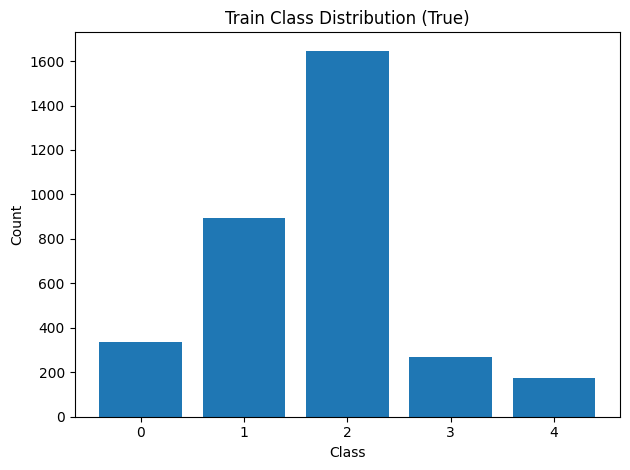

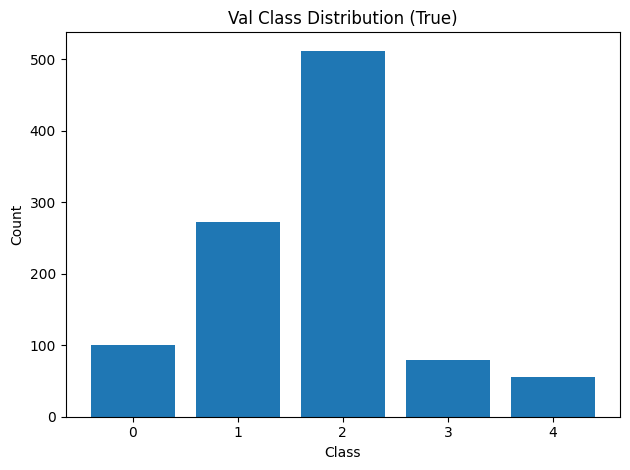

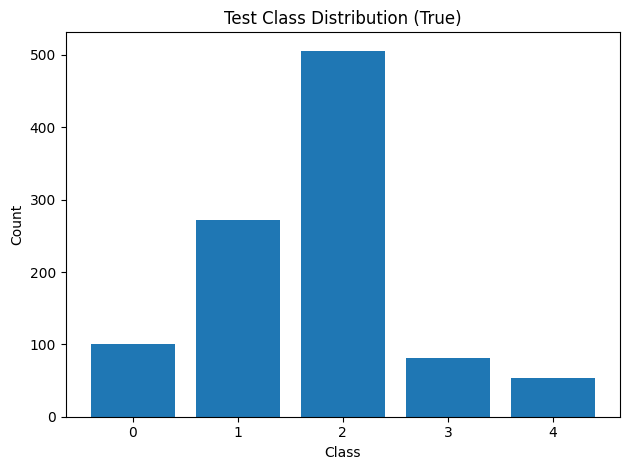

In [ ]:

# Plot the distributions
_plot_class_dist(_labels_from_dataloader(train_dl), "Train Class Distribution (True)")
_plot_class_dist(_labels_from_dataloader(val_dl),   "Val Class Distribution (True)")
try:
    _plot_class_dist(_labels_from_dataloader(test_dl),  "Test Class Distribution (True)")
except:
    pass

In [ ]:
import timm

MODEL_PATH = "/content/best_efficientnet_dr.pth"

deploy_model = timm.create_model("tf_efficientnet_b3_ns", pretrained=False, num_classes=5)
deploy_model.load_state_dict(torch.load(MODEL_PATH, map_location="cpu"))
deploy_model.eval()

scripted_model = torch.jit.script(deploy_model)

TS_PATH = "dr.pt"
scripted_model.save(TS_PATH)

print(f"TorchScript model saved at {TS_PATH}")

/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b3_ns to current tf_efficientnet_b3.ns_jft_in1k.
  model = create_fn(


TorchScript model saved at dr.pt


In [ ]:
    import shutil
    import os
    from google.colab import files

    folder_to_zip = "/content/DFU_org"
    zip_filename = f"{folder_to_zip}.zip"

    shutil.make_archive(folder_to_zip, 'zip', folder_to_zip)
